# Spotify Top 100 P2 -  EDA, MVP

Question: Can a top 100 song be predicted? What are the features that make a song hit the top 100 or even top 10 streams on Spotify?

EDA Procedures
1. First, I'll combine the two data sets removing repeated features
2. Then, I will split the data for a hold out set and visualize the distribution of the target variable (for imballances) and a pairplot (for feature distributions & multioclinearity)
2. Next, I will try and get a good base line model, pick a scoring metric, and...
6. Finaly, determine if more data from another source should be added or if even more features should be engineered.

## Part 1 - Importing, Combining & Cleaning  

In [1]:
import pandas as pd

In [2]:
top_100 = pd.read_csv('top_100.csv')
decade_1000 = pd.read_csv('decade_hits.csv')

songs_df = pd.concat([top_100, decade_1000], ignore_index=True)

songs_df.shape

(1100, 18)

In [3]:
songs_df.head()

,Unnamed: 0,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,top100,top10
0,0,ROCKSTAR,DaBaby,0.746,0.690,11,-7.956,1,0.1640,0.24700,0.000000,0.1010,0.497,90,181733,4,1,1
1,1,Savage Love,Jawsh 685,0.767,0.481,0,-8.520,0,0.0803,0.23400,0.000000,0.2690,0.761,150,171375,4,1,1
2,2,Blinding Lights,The Weeknd,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171,200040,4,1,1
3,3,Watermelon Sugar,Harry Styles,0.548,0.816,0,-4.209,1,0.0465,0.12200,0.000000,0.3350,0.557,95,174000,4,1,1
4,4,Roses - Imanbek Remix,SAINt JHN,0.785,0.721,8,-5.457,1,0.0506,0.01490,0.004320,0.2850,0.894,122,176219,4,1,1


In [4]:
# remove the index column and  time_signature because more that most songs are in 4
songs_df.drop(['Unnamed: 0', 'time_signature'], axis=1, inplace=True)

# removing duplicates
duplicate_attrs = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence',
                  'tempo', 'duration_ms']

songs_df.drop_duplicates(duplicate_attrs, ignore_index=True, inplace=True)
songs_df.shape

(942, 16)

In [5]:
# get dummies for "key" and remove "key"
key_dummies_df = pd.get_dummies(songs_df['key'], drop_first=True)
songs_wdummies = pd.concat([songs_df.drop('key', axis=1), key_dummies_df], axis=1)

songs_wdummies.head(2)

,track,artist,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,2,3,4,5,6,7,8,9,10,11
0,ROCKSTAR,DaBaby,0.746,0.690,-7.956,1,0.1640,0.247,0.0,0.101,...,0,0,0,0,0,0,0,0,0,1
1,Savage Love,Jawsh 685,0.767,0.481,-8.520,0,0.0803,0.234,0.0,0.269,...,0,0,0,0,0,0,0,0,0,0


In [6]:
songs_wdummies.columns     # note: 0 (key of C) was omitted

Index([           'track',           'artist',     'danceability',
                 'energy',         'loudness',             'mode',
            'speechiness',     'acousticness', 'instrumentalness',
               'liveness',          'valence',            'tempo',
            'duration_ms',           'top100',            'top10',
                        1,                  2,                  3,
                        4,                  5,                  6,
                        7,                  8,                  9,
                       10,                 11],
      dtype='object')

Spotify's explanation of column attributes can be found [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

## Part 2 - Hold out & Visualize

In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
entire_X = songs_wdummies.drop(['track', 'artist', 'top100', 'top10'], axis=1)
entire_y = songs_wdummies['top100']

X, X_test, y, y_test = train_test_split(entire_X, entire_y, random_state=111, test_size=.2)

# Just making sure SOME "top 100" tracks slipped in
y_test[y_test == 1].count()

21

Number of Other Songs:  676
Number of Top 100s:  77


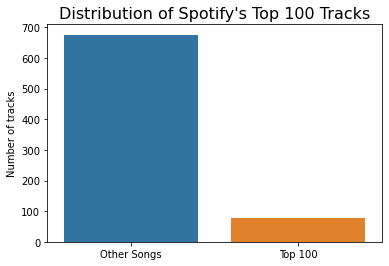

In [9]:
ax = sns.barplot(['Other Songs', 'Top 100'], pd.Series(y).value_counts())
ax.set(ylabel='Number of tracks')
ax.set_title("Distribution of Spotify's Top 100 Tracks", fontsize=16);

print("Number of Other Songs: ", pd.Series(y).value_counts()[0])
print("Number of Top 100s: ", pd.Series(y).value_counts()[1])

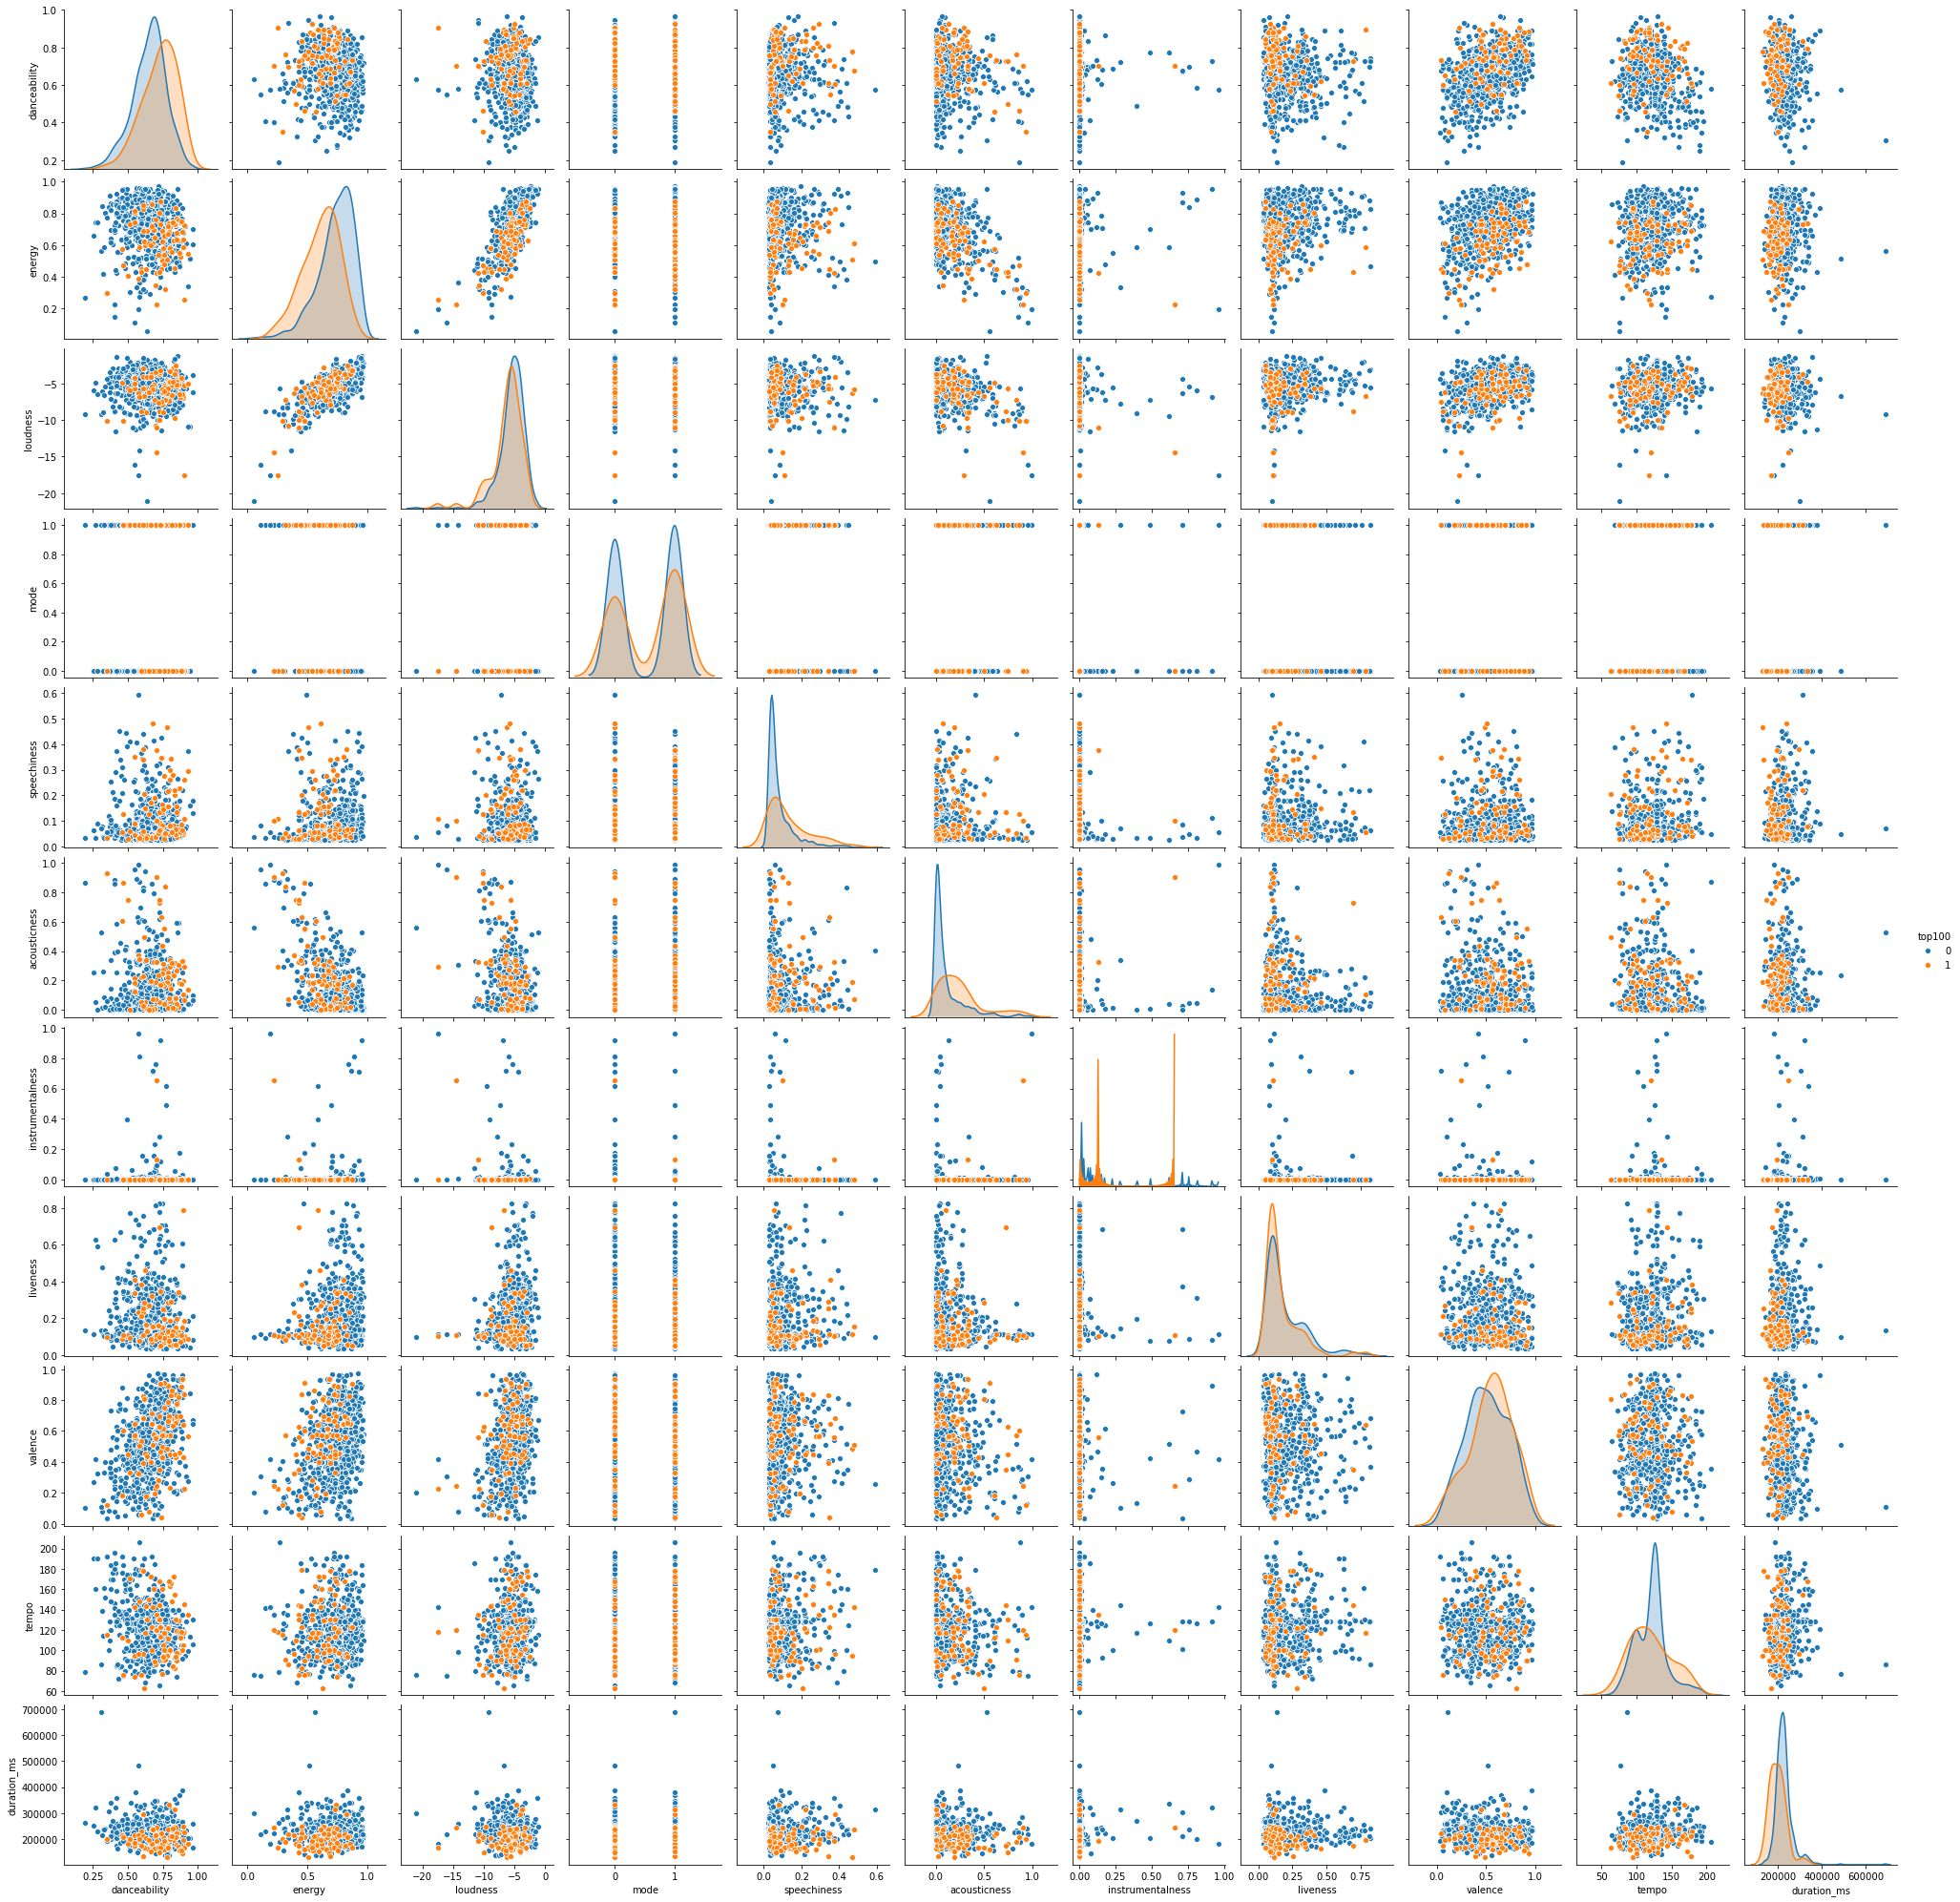

In [10]:
# This Cell Takes a while!

X_wo_dums = X.iloc[:, :11]

full_train = pd.concat([X_wo_dums, y], axis=1)

sns.pairplot(full_train, hue='top100');

## Part 3 - Dummy and Baseline Model

Plan
- Because of the high class imballance: use Logistic Regression, SVM, and Random Forest in conjunction with stratified cross validation. As a metric, F1 score

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [12]:
def scale(X, X_test, dummy_idx):
    # separate dummy columns
    X_, X_dums = np.split(X, [dummy_idx], axis=1)
    X_t, Xt_dums = np.split(X_test, [dummy_idx], axis=1)
    # scale numerical attributes
    mms = MinMaxScaler()
    X_ = mms.fit_transform(X_)
    X_t = mms.transform(X_t)
    # back together 
    return (np.concatenate((X_, X_dums), axis=1), 
            np.concatenate((X_t, Xt_dums), axis=1))


def run_skf(X, y, model=LogisticRegression(C=100), dummy_idx=11):
    X_, y_= np.array(X), np.array(y)
    f1s = []
    
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
    
    for train_idx, val_idx in skf.split(X_, y_):
        X_train, X_val = scale(X_[train_idx], X_[val_idx], dummy_idx)
        y_train, y_val = y_[train_idx], y_[val_idx]
        
        model.fit(X_train, y_train)
        f1s.append(f1_score(y_val, model.predict(X_val)))
    
    return f'F1 score : {np.mean(f1s)}'

In [13]:
print('Dummy Model F1 score :', f1_score(y, [0]*len(y)))
print('Logistic Regression', run_skf(X, y))
print('SVM', run_skf(X, y, model=SVC(C=100)))
print('Random Forest', run_skf(X, y, model=RandomForestClassifier(n_estimators=1000)))

Dummy Model F1 score : 0.0
Logistic Regression F1 score : 0.3401572112098427
SVM F1 score : 0.3149533844189017
Random Forest F1 score : 0.24241235888294713


## Part 4 - Final Notes 

- resample, adjust weights, adjust threshold, and look at the ROC/AUC.
- Add several columns from instagram
- Look at Pecision & Recall (Emphasis on Precision) & consider F1 beta

In [14]:
songs_wdummies.to_csv('songs_wdummies.csv')